# Dark frame analyses on NIRcam & 1/f noise, pt. I: data modelling
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: Mar 23, 2021

## Introduction

As discussed in Part 1 of this notebook, we are on the lookout for a good model for our data. Here we will try some of them and discuss these results. Let's start by loading some libraries:

In [57]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Celerite and PyMultiNest:
import celerite2
from celerite2 import terms
import pymultinest

# Lomb-scargle magic:
from astropy.timeseries import LombScargle

# Corner for plotting purposes:
import corner

## 1. Modelling read-noise with `celerite`

Let's perform inference on the time-series of amplifier 2 using `celerite`. To this end, we couple `celerite` with `PyMultiNest` in order to optimize the parameters. We first try a stochastically-driven damped harmonic oscillator (SHO) model plus a white-noise term which seems to follow more or less the expected shape of our PSD above (see Figure 1 in the [Foreman-Mackey et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332/meta) paper). 

### 1.1 Fitting the first group only

For testing purposes, let's first fit the first group of the NIRCam amplifier 2 data. Let's load the data for this group (which we saved in our previous notebook):

In [2]:
x, y = np.load('times_sec_group_0.npy'), np.load('corrected_group_0.npy')
yerr = np.ones(len(y))

Let's compute some stats on this dataset:

In [3]:
print(x.shape)
tmin, tmax = np.min(np.abs(np.diff(x))), np.max(x) - np.min(x)
ymin, ymax = np.min(y), np.max(y)
print('Min and max time-scales:', tmin, tmax)
print('Min and max counts:', ymin, ymax)

(1046199,)
Min and max time-scales: 9.999999999621423e-06 10.73139
Min and max counts: -55.24384880065918 57.76782035827637


Note this is a _huge_ dataset (haven't used `celerite` with such big datasets before!). 

All right, let's initialize the celerite model. We'll use the SHO model parametrization that constrains it using three parameters that make intuitive sense: 

1. The **standard deviation of the process, $\sigma_{GP}$**, which we know is bounded from above as we know the overall fluctuation of the dataset (see Min and max counts above).

2. The **undamped period of the oscillator, $\rho$**, which sets a typical time-scale for the problem. Given our time-scales are also bounded (see Min amd max time-scales, above), this parameter is also bounded.

3. The **quality factor of the damped harmonic oscillator, $Q$**. We know this process is non-periodic, so this should be fixed --- but let's try to fit it anyways. Let's define it to be smaller than about 2 (see Figure 1 in [Foreman-Mackey et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332/meta)).


In [4]:
kernel = terms.SHOTerm(sigma=1.0, rho=0.1, Q = 2.)
gp = celerite2.GaussianProcess(kernel, mean=0.)

Let's now define the prior transforms we will be using (this is Nested Sampling jargon, but basically, Nested Samplers sample in the unit cube --- so to sample with arbitrary distributions, we have to transform those samples to suit our needs). We'll be using uniform and log-uniform priors:

In [5]:
def transform_uniform(x,a,b):
    return a + (b-a)*x

def transform_loguniform(x,a,b):
    la=np.log(a)
    lb=np.log(b)
    return np.exp(la + x*(lb-la))

### 1.1.1 Fitting for $\sigma_{GP}$, $\rho$ and $Q$

Now define the prior and the likelihood. We will be fitting for four terms. The first three terms will be defining the SHO itself: the standard deviation of the process, $\sigma_{GP}$, the undamped period of the oscillator, $\rho$ and the damping time-scale of the process, $\tau$ (see the `SHOTerm` definition in `celerite` [here](https://celerite2.readthedocs.io/en/latest/api/python/#python-recommended)). The fourth term is a white-noise component, $\sigma_w$ --- so we will be modelling our process as a SHO on top of white-noise:

In [6]:
def prior(cube, ndim, nparams):
    # Prior on sigma_w in units of counts; note the upper limit is 100, 
    # which is the overal amplitude of the dataset itself (see Min and max counts above):
    cube[0] = transform_loguniform(cube[0], 1., 100.)
    # Prior on sigma_GP, rho and tau:
    # sigma_GP covers same ground as sigma_w:
    cube[1] = transform_loguniform(cube[1], 1., 100.)
    # Prior on rho, covering all relevant time-scales:
    cube[2] = transform_loguniform(cube[2], tmin, tmax)
    # Uniform prior on Q; smaller than 2, larger than 0:
    cube[3] = transform_uniform(cube[3], 0., 2.)
    
def loglike(cube, ndim, nparams):
    # Extract parameters
    sigma_w, sigma_gp, rho, Q = cube[0], cube[1], cube[2], cube[3]
    # Assume zero-mean process:
    gp.mean = 0.
    # Set GP kernel, compute with diagonal errors:
    gp.kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho, Q = Q)
    gp.compute(x, diag=(yerr*sigma_w)**2, quiet=True)
    # Return log-likelihood
    return gp.log_likelihood(y)

It is important to note, before moving forward, that the underlying assumption behind this log-likelihood is that the data is _normally distributed_. This is, of course, only an approximation --- we _know_ the underlying process is Poisson (at the very least the white-noise part of it). Good news is that for rates as small as 3-4 the Gaussian approximation is actually pretty good (but this nonetheless should be kept in mind). 

All right, now let's fit this (beware --- this takes _a while_; about ten minutes on my laptop)!

In [7]:
n_params = 4

In [7]:
pymultinest.run(loglike, prior, n_params, n_live_points = 100, \
                outputfiles_basename='one_group_fit', resume = False, verbose = True)

Let's extract the posterior parameter distributions:

In [8]:
# Get output, weight posteriors:
output = pymultinest.Analyzer(outputfiles_basename='one_group_fit', n_params = n_params)
posterior_samples = output.get_equal_weighted_posterior()[:,:-1]

# Get posterior samples:
sigma_w_samples = posterior_samples[:,0]
sigma_gp_samples = posterior_samples[:,1]
rho_samples = posterior_samples[:,2]
Q_samples = posterior_samples[:,3]

  analysing data from one_group_fit.txt


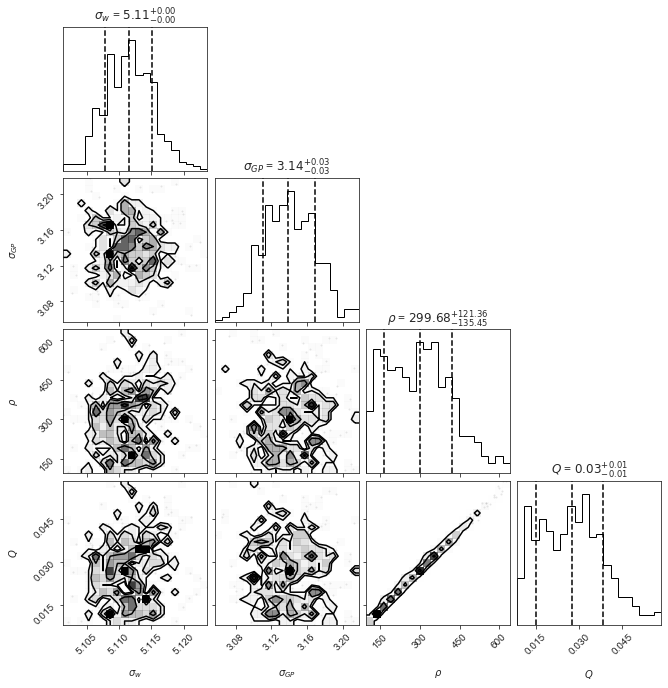

In [9]:
# Before plotting it, transform rho to micro-seconds --- which is a better time-scale for plotting this process:
ps = np.copy(posterior_samples)
ps[:,2] = ps[:,2]*1e6

# Plot it:
figure = corner.corner(ps, labels=[r"$\sigma_w$", r"$\sigma_{GP}$", r"$\rho$", r"$Q$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

All right! It seems $Q$ and $\rho$ are very correlated with each other. This makes sense! Looking at Figure 1 in [Foreman-Mackey et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332/meta), for non-periodic processes, changing $\rho = 2\pi/\omega_0$ just changes the scaling --- hence why these two parameters are so correlated.

We'll do a fit leaving $Q$ fixed below, but first, let's plot a section of the time-series to see how well we did with our GP:

Text(0.5, 1.0, 'Posterior GP prediction (conditioned on data)')

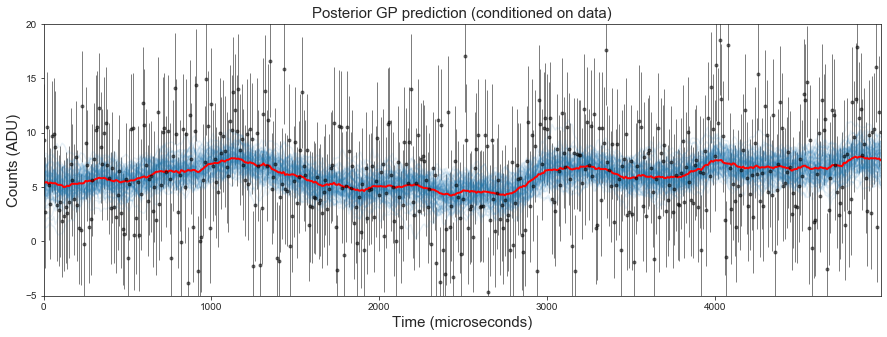

In [10]:
# Plot time-series:
idx = np.where(x<5*1e-3)[0]
plt.figure(figsize=(15,5))
plt.errorbar(x[idx]*1e6, y[idx], yerr=yerr[idx]*np.median(sigma_w_samples),fmt='.', \
             alpha=0.5, elinewidth=1, color='black')

# Plot some sample predictions from GP on top:
first_time = True
for sample in posterior_samples[np.random.randint(posterior_samples.shape[0], size=100)]:
    # Extract sample:
    sigma_w, sigma_gp, rho, Q = sample
    # Compute GP:
    gp.kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho, Q = Q)
    gp.compute(x[idx], diag=(yerr[idx]*sigma_w)**2, quiet=True)
    # Condition GP on data:
    conditional = gp.condition(y[idx], x[idx])
    # Plot sample:
    sample = conditional.sample()
    plt.plot(x[idx]*1e6, sample, color="C0", alpha=0.1)
    if first_time:
        all_samples = np.copy(sample)
        first_time = False
    else:
        all_samples = np.vstack((all_samples, np.copy(sample)))
        
# Plot median of all model samples as the median model:
plt.plot(x[idx]*1e6, np.median(all_samples, axis = 0), color="red", lw = 2)

# Set labels:
plt.xlim(np.min(x[idx])*1e6,np.max(x[idx])*1e6)
plt.ylim(-5,20)
plt.xlabel('Time (microseconds)', fontsize=15)
plt.ylabel('Counts (ADU)', fontsize=15)
plt.title('Posterior GP prediction (conditioned on data)', fontsize=15)

**What about the power-spectral density shape of this GP?** In principle, `celerite` has some functionality to generate those, but is not very good because it only computes the GP part _without_ white-noise. However, the trick here is to compute the PSD _numerically_ and plot that on top of the PSD of the data. This also makes it easier to compare against the actual data, because all those pesky normalizations of e.g., lomb-scargle periodograms are the same!

Let's start by defining the frequency range:

In [21]:
freq = np.linspace(1./5.,1./2e-5,65536)

Now let's sample a handful of times from the prior implied by the different samples of the GP parameters, add white-noise to those samples using the `sigma_w` value, and compute the PSD using the lomb-scargle periodogram. Later, we just average those samples out to compute the mean PSD:

Text(0, 0.5, 'PSD')

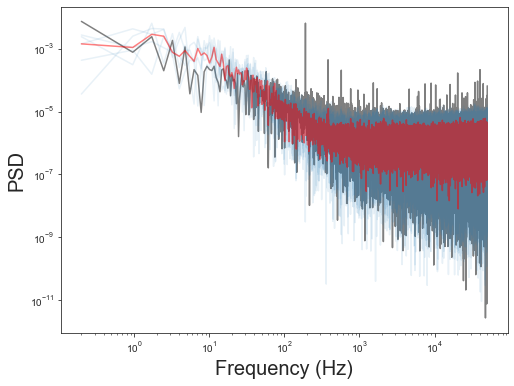

In [36]:
first_time = True
ndata = len(x)

plt.figure(figsize=(8,6))

for sample in posterior_samples[np.random.randint(posterior_samples.shape[0], size=5)]:
    
    # Extract sample:
    sigma_w, sigma_gp, rho, Q = sample
    
    # Compute GP:
    gp.kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho, Q = Q*1e-1)
    gp.compute(x, quiet=True)
    # Sample from prior defined by those parameters:
    sample = gp.sample()
    
    # Add white-noise to this:
    sample = sample + np.random.normal(0., sigma_w, ndata)
    
    # Compute PSD using lomb-scargle magic:
    power = LombScargle(x, sample).power(freq)
    
    # Plot PSD:
    plt.loglog(freq, power, color="C0", alpha=0.1, zorder = 1)
    if first_time:
        all_psds = np.copy(power)
        first_time = False
    else:
        all_psds = np.vstack((all_psds, np.copy(power)))
        
# Compute PSD of the data:
power_data = LombScargle(x, y).power(freq)
plt.loglog(freq, power_data, zorder = 0, color='black', alpha = 0.5)

# And compute the mean PSD of the model:
plt.loglog(freq, np.median(all_psds, axis = 0), zorder = 2, color = 'red', alpha = 0.5)

plt.xlabel('Frequency (Hz)', fontsize = 20)
plt.ylabel('PSD', fontsize = 20)

All right --- good but not perfect, even in this correlated regime. It seems that is trying to fit the initial bump at around $10^3$ Hz, but then keeps going up. We probably need two components: one that takes care of that bump, and another one that takes care of the long tail to lower frequencies. **Let's try two non-periodic components below to fit this dataset!**

### 1.1.2 Fitting for $\sigma_{GP}$ and $\rho$ only --- two term GP 

Let's use two non-periodic components to fit our dataset. The first will take care of the bump at around $10^3$ Hz above, the other will take care of the "tail" ---- in this way we can "emulate" a 1/f process with only 5 parameters! We will fix $Q = 0.25$ for both components.

Let's re-write the prior and log-likelihood of this new model:

In [49]:
def prior2(cube, ndim, nparams):
    # Prior on sigma_w in units of counts; note the upper limit is 100, 
    # which is the overal amplitude of the dataset itself (see Min and max counts above):
    cube[0] = transform_loguniform(cube[0], 1., 100.)
    # Prior on sigma_GP and rho of the first component:
    # sigma_GP covers same ground as sigma_w:
    cube[1] = transform_loguniform(cube[1], 1., 100.)
    # Prior on rho, covering all relevant time-scales:
    cube[2] = transform_loguniform(cube[2], tmin, tmax)
    # Repeat for the second term:
    cube[3] = transform_loguniform(cube[3], 1., 100.)
    # Prior on rho, covering all relevant time-scales:
    cube[4] = transform_loguniform(cube[4], tmin, tmax)    
    
def loglike2(cube, ndim, nparams):
    # Extract parameters
    sigma_w, sigma1_gp, rho1, sigma2_gp, rho2 = cube[0], cube[1], cube[2], cube[3], cube[4]
    
    # Force rho1 to be larger than rho2 (otherwise we will have two modes!)
    if rho1 < rho2:
        return -1e101
    # Assume zero-mean process:
    gp.mean = 0.
    
    # Set GP kernel, compute with diagonal errors:
    gp.kernel = terms.SHOTerm(sigma=sigma1_gp, rho=rho1, Q = 0.25) +\
                terms.SHOTerm(sigma=sigma2_gp, rho=rho2, Q = 0.25)
    
    gp.compute(x, diag=(yerr*sigma_w)**2, quiet=True)
    
    # Return log-likelihood
    return gp.log_likelihood(y)

In [50]:
n_params = 5

And let's run this fit!

In [51]:
pymultinest.run(loglike2, prior2, n_params, n_live_points = 100, \
                outputfiles_basename='one_group_fit_two_term', resume = False, verbose = True)

Let's explore the posterior distribution of this two-term GP:

In [52]:
# Get output, weight posteriors:
output = pymultinest.Analyzer(outputfiles_basename='one_group_fit_two_term', n_params = n_params)
posterior_samples = output.get_equal_weighted_posterior()[:,:-1]

# Get posterior samples:
sigma_w_samples = posterior_samples[:,0]
sigma1_gp_samples = posterior_samples[:,1]
rho1_samples = posterior_samples[:,2]
sigma2_gp_samples = posterior_samples[:,3]
rho2_samples = posterior_samples[:,4]

  analysing data from one_group_fit_two_term.txt


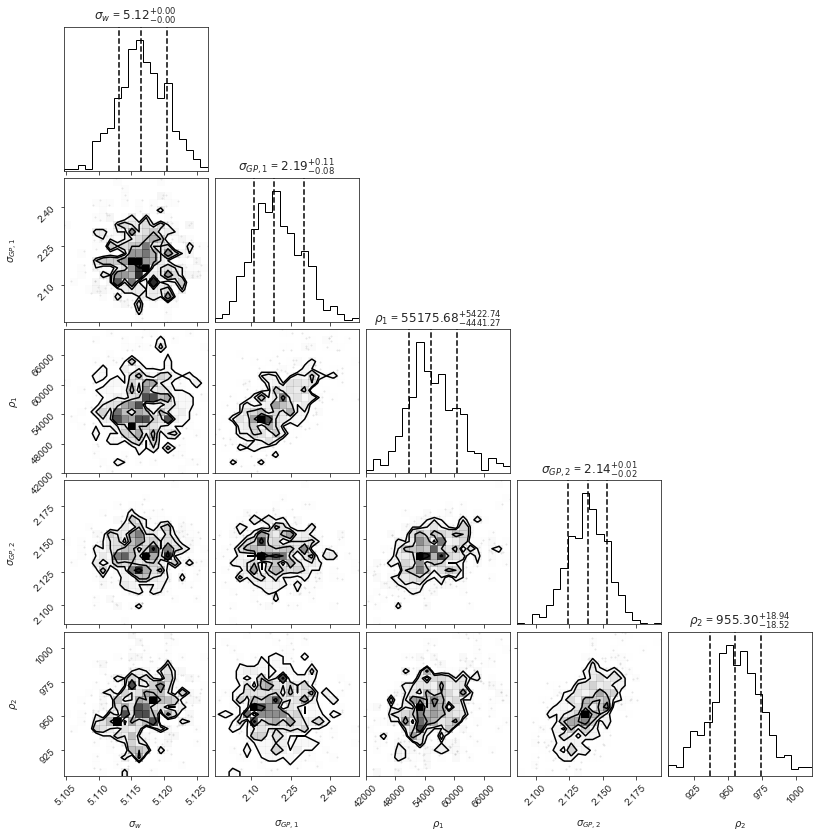

In [53]:
# Before plotting it, transform rho to micro-seconds --- which is a better time-scale for plotting this process:
ps = np.copy(posterior_samples)
ps[:,2] = ps[:,2]*1e6
ps[:,4] = ps[:,4]*1e6

# Plot it:
figure = corner.corner(ps, labels=[r"$\sigma_w$", r"$\sigma_{GP,1}$", r"$\rho_1$", r"$\sigma_{GP,2}$", r"$\rho_2$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

All right, that looks OK I guess.

Let's plot once again the GP samples conditioned on the data:

Text(0.5, 1.0, 'Posterior GP prediction (two-term, conditioned on data)')

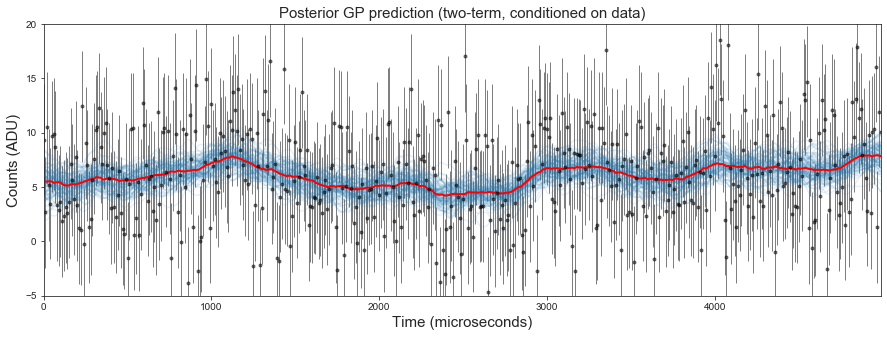

In [54]:
# Plot time-series:
idx = np.where(x<5*1e-3)[0]
plt.figure(figsize=(15,5))
plt.errorbar(x[idx]*1e6, y[idx], yerr=yerr[idx]*np.median(sigma_w_samples),fmt='.', \
             alpha=0.5, elinewidth=1, color='black')

# Plot some sample predictions from GP on top:
first_time = True
for sample in posterior_samples[np.random.randint(posterior_samples.shape[0], size=100)]:
    # Extract sample:
    sigma_w, sigma1_gp, rho1, sigma2_gp, rho2 = sample
    # Compute GP:
    gp.kernel = terms.SHOTerm(sigma=sigma1_gp, rho=rho1, Q = 0.25) +\
                terms.SHOTerm(sigma=sigma2_gp, rho=rho2, Q = 0.25)
    gp.compute(x[idx], diag=(yerr[idx]*sigma_w)**2, quiet=True)
    # Condition GP on data:
    conditional = gp.condition(y[idx], x[idx])
    # Plot sample:
    sample = conditional.sample()
    plt.plot(x[idx]*1e6, sample, color="C0", alpha=0.1)
    if first_time:
        all_samples = np.copy(sample)
        first_time = False
    else:
        all_samples = np.vstack((all_samples, np.copy(sample)))
        
# Plot median of all model samples as the median model:
plt.plot(x[idx]*1e6, np.median(all_samples, axis = 0), color="red", lw = 2)

# Set labels:
plt.xlim(np.min(x[idx])*1e6,np.max(x[idx])*1e6)
plt.ylim(-5,20)
plt.xlabel('Time (microseconds)', fontsize=15)
plt.ylabel('Counts (ADU)', fontsize=15)
plt.title('Posterior GP prediction (two-term, conditioned on data)', fontsize=15)

That looks nice! And the PSD?

Text(0, 0.5, 'PSD')

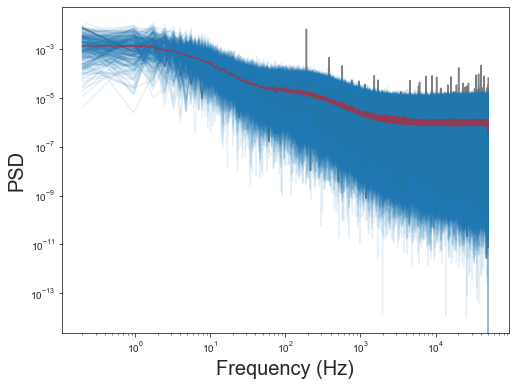

In [56]:
first_time = True
ndata = len(x)

plt.figure(figsize=(8,6))

for sample in posterior_samples[np.random.randint(posterior_samples.shape[0], size=300)]:
    
    # Extract sample:
    sigma_w, sigma1_gp, rho1, sigma2_gp, rho2 = sample
    # Compute GP:
    gp.kernel = terms.SHOTerm(sigma=sigma1_gp, rho=rho1, Q = 0.25) +\
                terms.SHOTerm(sigma=sigma2_gp, rho=rho2, Q = 0.25)
    
    gp.compute(x, quiet=True)
    # Sample from prior defined by those parameters:
    sample = gp.sample()
    
    # Add white-noise to this:
    sample = sample + np.random.normal(0., sigma_w, ndata)
    
    # Compute PSD using lomb-scargle magic:
    power = LombScargle(x, sample).power(freq)
    
    # Plot PSD:
    plt.loglog(freq, power, color="C0", alpha=0.1, zorder = 1)
    if first_time:
        all_psds = np.copy(power)
        first_time = False
    else:
        all_psds = np.vstack((all_psds, np.copy(power)))
        
# Compute PSD of the data:
power_data = LombScargle(x, y).power(freq)
plt.loglog(freq, power_data, zorder = 0, color='black', alpha = 0.5)

# And compute the mean PSD of the model:
plt.loglog(freq, np.median(all_psds, axis = 0), zorder = 2, color = 'red', alpha = 0.5)

plt.xlabel('Frequency (Hz)', fontsize = 20)
plt.ylabel('PSD', fontsize = 20)

Wow --- that model looks _awesome_. Let's try to fit _all groups_ next!

### 1.2 Fitting _all the groups_ simultaneously

OK, now let's constrain the GP parameters by using _all the data_. One important detail is that the formal model for our data, given groups are up-the-ramp samples, is something of the form

$G(n) = G(n-1) + A_n + \epsilon_n$

where $G(n)$ is group number $n$, and by definition of our experiments, $G(-1) = 0$. $A_n$ represents the group-dependent bias level, which we already removed in Part 1. $\epsilon_n$ is the _realization_ of a stochastic process $\epsilon$ generating the read-noise, including the white-noise component, which is the process we are interested in constraining.

Because group $G(n)$ contains the realization of the process in all the previous groups through the $G(n-1)$ term, in order to constrain the $\epsilon_n$ process what we really want is to take _the difference_ between consecutive groups, and model _that_ as a GP. This is why above I did the fitting on the first group --- the first group in our model above only has the bias (already removed) and the stochastic process realization $\epsilon_1$.

Let's generate thus the difference images and store that in an array. Note that in theory the times at which we have data for each time-sample is different (we did outlier rejection _on each group_ in Part 1), so we check _each_ time sample individually on each difference image. There are 108 groups for NIRCam, so we can in theory get 54 independent samples. The strategy will be to obtain 54 independent samples of $\epsilon$ by substracting group 1 from 2, group 4 from 3, group 6 from 5 and so on --- so note we always use the data once:

In [ ]:
dtimes, dgroups = [], []
counter = 0
for n in range(0, 108, 2):

    if not os.path.exists('difference_group_'+str(counter)+'.npy'):
        print('Running group difference ',counter)
        # Arrays that will store time-stamps and difference counts:
        difference_times = np.array([])
        difference_counts = np.array([])
    
        # Load current group and the next:
        current_time = np.load('times_sec_group_'+str(n)+'.npy')
        current_group = np.load('corrected_group_'+str(n)+'.npy')
        next_time = np.load('times_sec_group_'+str(n+1)+'.npy')
        next_group = np.load('corrected_group_'+str(n+1)+'.npy')
    
        # Loop through the times on the next group (optimal would be to check on which time-stamps/pixels both 
        # have data, but we ommit that here; doesn't make much of a difference). This loop below's credit 
        # goes to user lllrnr101 in StackOverflow (https://stackoverflow.com/questions/66781291/pythonic-way-of-finding-indexes-of-unique-elements-in-two-arrays):
        i, j = 0, 0
        while (i<len(next_time) and j<len(current_time)):
            if next_time[i] == current_time[j]:
                difference_times = np.append(difference_times, next_time[i])
                difference_counts = np.append(difference_counts, next_group[i] - current_group[j])
                
            elif (next_time[i] < current_time[j]):
                i += 1
            else:
                j += 1
            
        # Once done, save this so we do this only once:
        np.save('difference_times_sec_'+str(counter), difference_times)
        np.save('difference_group_'+str(counter), difference_counts)
        
        # Save to list:
        dtimes.append(np.copy(difference_times))
        dgroups.append(np.copy(difference_counts))
        
    else:
        dtimes.append(np.load('difference_times_sec_'+str(counter)+'.npy'))
        dgroups.append(np.load('difference_group_'+str(counter)+'.npy'))
    
    counter += 1

Running group difference  2
